In [7]:
import os
import sys
from claspy.data_loader import load_tssb_dataset
import numpy as np
from src.timeseries_dataset import TimeSeriesDataset
import matplotlib.pyplot as plt

In [2]:
# Get random subsequence from the sequence
def get_random_subsequence(sequence, percentage):
    seq_length = len(sequence)
    length = int(percentage * seq_length)

    max_start_index = seq_length - length
    start_index = np.random.randint(0, max_start_index)

    return sequence[start_index : start_index + length]


# Prepare custom the dataset
def prepare_dataset(
    name, segment_types, segment_num=10, len_perc_min=0.6, len_perc_max=0.8
):
    _, _, true_cps, time_series = load_tssb_dataset(names=(name,)).iloc[0, :]

    labels = []
    sequences = [time_series[0 : true_cps[0] - 1]]
    for i in range(segment_types - 2):
        sequences.append(time_series[true_cps[i] : true_cps[i + 1] - 1])
    sequences.append(time_series[true_cps[-1] : len(time_series)])

    segments = []
    last_idx = -1
    missing_segment = True
    while missing_segment:
        labels = []
        for _ in range(segment_num):
            idx = np.random.randint(0, segment_types)
            while idx == last_idx:
                idx = np.random.randint(0, segment_types)
            last_idx = idx

            segments.append(
                get_random_subsequence(
                    sequences[idx], np.random.uniform(len_perc_min, len_perc_max)
                )
            )
            labels.append(idx)
        unique_labels = len(np.unique(labels))
        if unique_labels == segment_types:
            missing_segment = False

    return segments, np.array(labels)


# Create sinus signal
def prepare_sinus_signal(segment_types=2, segment_num=10, segment_length=1000, noise=0):
    time = np.arange(0, segment_length, 1)
    sinus_signals = []
    for i in range(segment_types):
        sinus_signals.append(np.sin(time / (i + 1)))

    last_idx = -1
    missing_segment = True
    while missing_segment:
        segments = []
        labels = []
        for _ in range(segment_num):
            idx = np.random.randint(0, segment_types)
            while idx == last_idx:
                idx = np.random.randint(0, segment_types)
            last_idx = idx

            segments.append(
                sinus_signals[idx] + np.random.normal(0, noise, segment_length)
            )
            labels.append(idx)
        unique_labels = len(np.unique(labels))
        if unique_labels == segment_types:
            missing_segment = False

    return segments, np.array(labels)

In [3]:
gen_path = "data/generated"


def save_dataset(name, size, clusters):
    segments, original_labels = prepare_dataset(
        name, clusters, size, len_perc_min=0.3, len_perc_max=0.8
    )
    segments_array = np.concatenate(segments)

    cp = 0
    cutpoints = [cp]
    for segment in segments:
        cp += len(segment)
        cutpoints.append(cp)
    cutpoints = np.array(cutpoints)
    np.savez(
        f"{gen_path}/{name}_{size}.npz",
        segments_array=segments_array,
        original_labels=original_labels,
        cutpoints=cutpoints,
    )

In [6]:
names = [
    "Plane",
    "NonInvasiveFetalECGThorax1",
    "UWaveGestureLibraryX",
    "UWaveGestureLibraryAll",
    "EOGHorizontalSignal",
    "ProximalPhalanxTW",
    "SwedishLeaf",
    "Symbols",
    "Car",
    "InlineSkate",
]
clusters = [7, 6, 5, 5, 4, 4, 4, 4, 4, 3]

for name, cluster in zip(names, clusters):
    save_dataset(name, 100, cluster)

In [4]:
def generate_gaussian_error(segments, error_percentage=0, error_std=0):
    for segment in segments:
        n_segment = len(segment)
        n_error = int(error_percentage * n_segment)
        error_indices = np.random.choice(n_segment, n_error, replace=False)
        mean_error = 0
        std_error = max(segment) * error_std  # Standard deviation of the Gaussian noise
        gaussian_noise = np.random.normal(mean_error, std_error, n_error)
        segment[error_indices] += gaussian_noise

    return segments

In [5]:
datasets = [
    "Plane",
    "NonInvasiveFetalECGThorax1",
    "UWaveGestureLibraryX",
    "UWaveGestureLibraryAll",
    "EOGHorizontalSignal",
    "ProximalPhalanxTW",
    "SwedishLeaf",
    "Symbols",
    "Car",
    "InlineSkate",
]
gaussian_path = "data/gaussian"

for name in datasets:
    for i in range(1, 11):
        for j in range(1, 11):
            dataset = TimeSeriesDataset(name, 1000)
            generate_gaussian_error(
                dataset.segments, error_percentage=i / 10, error_std=j / 10
            )
            segments_array = np.concatenate(dataset.segments)

            cp = 0
            cutpoints = [cp]
            for segment in dataset.segments:
                cp += len(segment)
                cutpoints.append(cp)
            cutpoints = np.array(cutpoints)
            if not os.path.exists(f"{gaussian_path}/{name}"):
                os.makedirs(f"{gaussian_path}/{name}")
            np.savez(
                f"{gaussian_path}/{name}/{name}_{1000}_{i}_{j}.npz",
                segments_array=segments_array,
                original_labels=dataset.labels,
                cutpoints=cutpoints,
            )

NameError: name 'load_dataset' is not defined

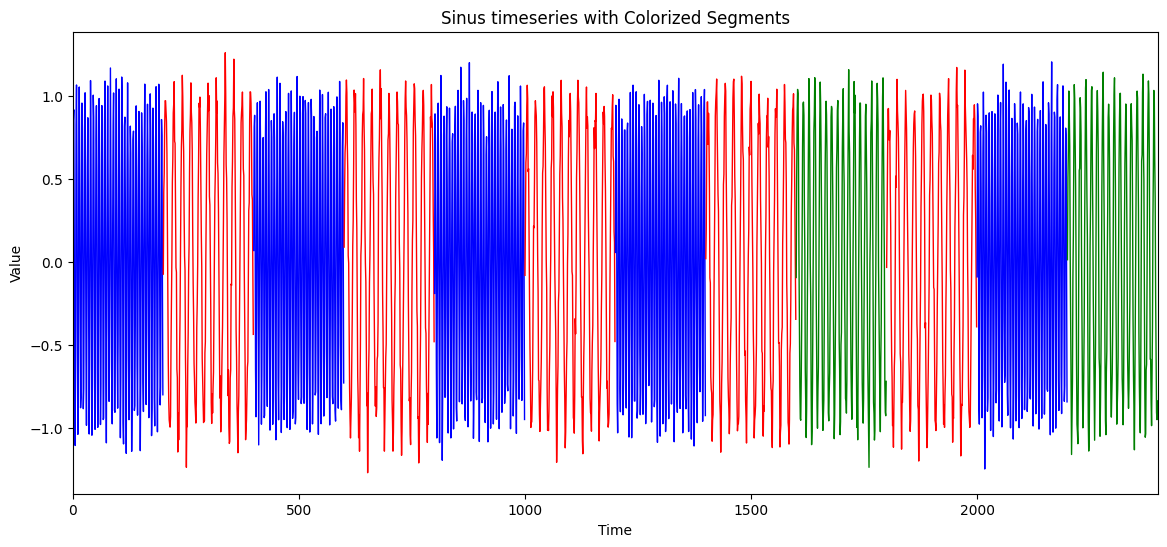

In [17]:
segments, original_labels = prepare_sinus_signal(3, 12, 200, noise=0.1)

segments_array = np.concatenate(segments)

cp = 0
cutpoints = [cp]
for segment in segments:
    cp += len(segment)
    cutpoints.append(cp)
cutpoints = np.array(cutpoints)
np.savez(
    f"{gen_path}/Sinus_12.npz",
    segments_array=segments_array,
    original_labels=original_labels,
    cutpoints=cutpoints,
)

sinus_ts = np.concatenate(segments, axis=0)
colors = ["b", "g", "r"]
start = 0
plt.figure(figsize=(14, 6))
for i, segment in enumerate(segments):
    end = start + len(segment)
    plt.plot(
        np.arange(start, end), segment, color=colors[original_labels[i]], linewidth=1
    )
    start = end


plt.xlabel("Time")
plt.xlim(0, len(sinus_ts))
plt.ylabel("Value")
plt.title("Sinus timeseries with Colorized Segments")
plt.show()

In [12]:
names = [
    "Plane",
    "NonInvasiveFetalECGThorax1",
    "UWaveGestureLibraryX",
    "UWaveGestureLibraryAll",
    "EOGHorizontalSignal",
    "ProximalPhalanxTW",
    "SwedishLeaf",
    "Symbols",
    "Car",
    "InlineSkate",
]

for k, name in enumerate(names):
    for i in range(11):
        for j in range(11):
            path = None
            if i == 0 or j == 0:
                path = f"data/distances_1k/basepoints/{name}/{name}_1000_0_0"
            else:
                path = f"data/distances_1k/basepoints/{name}/{name}_1000_{i}_{j}"

            if os.path.exists(f"{path}.npz"):
                try:
                    with np.load(f"{path}.npz") as data:
                        distance = data["distances"]
                    np.save(f"{path}.npy", distance)
                    os.remove(f"{path}.npz")
                except KeyError:
                    print(f"'distance' array not found in {path}.npz")
            else:
                print(f"{path}.npz not found, skipping.")

data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoints/Plane/Plane_1000_0_0.npz not found, skipping.
data/distances_1k/basepoi